## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import torch
from scipy.ndimage import gaussian_filter
from scipy.spatial import cKDTree
from scipy.stats import multivariate_normal

sys.path.append(os.path.abspath('../'))

from data import get_train_dataloader, get_test_dataloader
from gaussian import GaussianModel
from mri import MRI
from nn import NeuralNet, GaussianMapping, PosEncMapping
from utils import get_device

%load_ext autoreload
%autoreload 2

## Example

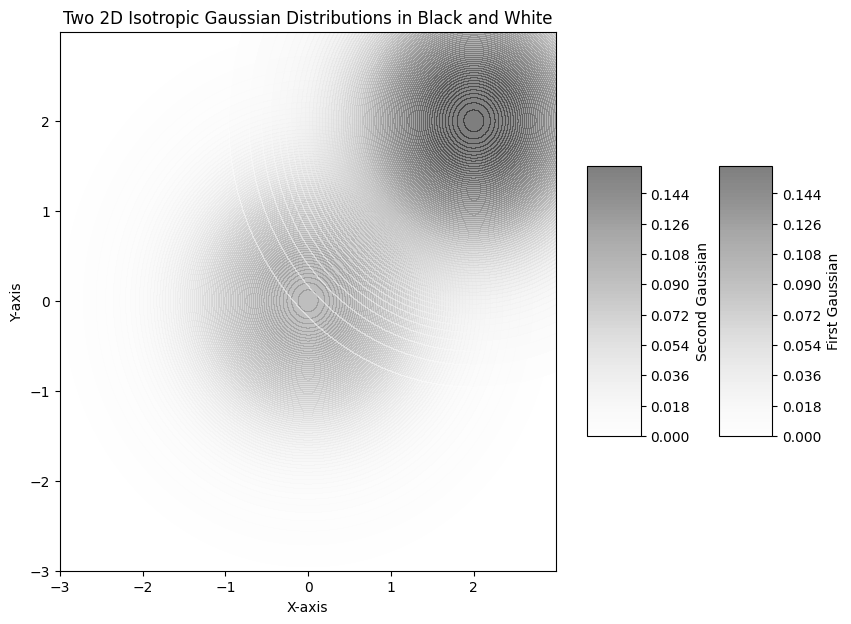

In [2]:
# Parameters for the two isotropic Gaussians
mean1 = [0, 0]  # Mean of the first Gaussian
sigma1 = 1      # Standard deviation for the first Gaussian
covariance_matrix1 = np.array([[sigma1**2, 0], [0, sigma1**2]])  # Covariance matrix for the first Gaussian

mean2 = [2, 2]  # Mean of the second Gaussian
sigma2 = 1    # Standard deviation for the second Gaussian
covariance_matrix2 = np.array([[sigma2**2, 0], [0, sigma2**2]])  # Covariance matrix for the second Gaussian

# Create a grid of (x,y) values
x, y = np.mgrid[-3:3:.01, -3:3:.01]
pos = np.dstack((x, y))

# Create the isotropic Gaussian distributions
rv1 = multivariate_normal(mean1, covariance_matrix1)
rv2 = multivariate_normal(mean2, covariance_matrix2)

# Plot the distributions with black and white color maps
fig, ax = plt.subplots(figsize=(10, 7))

# Adjust the contour plots to use a black and white colormap ('Greys')
contour1_bw = ax.contourf(x, y, rv1.pdf(pos), levels=100, cmap='Greys', alpha=0.5)
contour2_bw = ax.contourf(x, y, rv2.pdf(pos), levels=100, cmap='Greys', alpha=0.5)

# Add color bars for each contour plot using black and white
fig.colorbar(contour1_bw, ax=ax, shrink=0.5, aspect=5, label='First Gaussian')
fig.colorbar(contour2_bw, ax=ax, shrink=0.5, aspect=5, label='Second Gaussian')

ax.set_title('Two 2D Isotropic Gaussian Distributions in Black and White')
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')

plt.show()


In [3]:
# Coordinate to evaluate
point = np.array([1, 1])

# Evaluate the PDF of both Gaussians at the specified point
pdf_value1 = rv1.pdf(point)
pdf_value2 = rv2.pdf(point)

# Calculate the combined PDF value by adding them up
combined_pdf_value = pdf_value1 + pdf_value2

print(f"PDF value of the first Gaussian at {point}: {pdf_value1}")
print(f"PDF value of the second Gaussian at {point}: {pdf_value2}")
print(f"Combined PDF value at {point}: {combined_pdf_value}")


PDF value of the first Gaussian at [1 1]: 0.05854983152431917
PDF value of the second Gaussian at [1 1]: 0.05854983152431917
Combined PDF value at [1 1]: 0.11709966304863834


## Read MRI

In [4]:
lr_mri_path = '../../../hcp1200/996782/T1w_acpc_dc_restore_brain_downsample_factor_2.nii.gz'
lr_mri = MRI.from_nii_file(lr_mri_path)

12:25:35 | Reading data from ../../../hcp1200/996782/T1w_acpc_dc_restore_brain_downsample_factor_2.nii.gz


12:25:35 | Displaying relevant brain slices


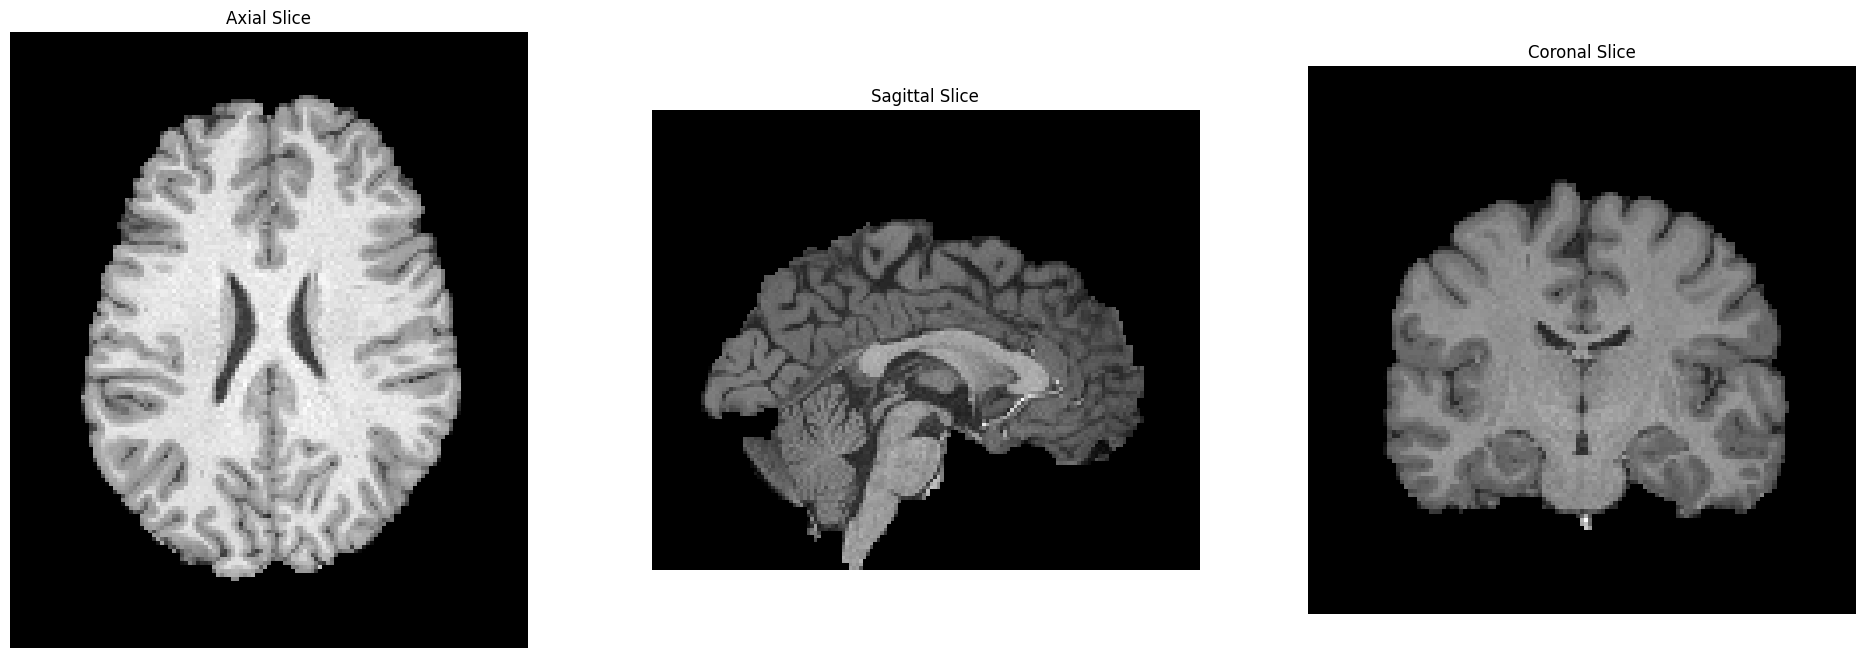

In [5]:
lr_mri.display_relevant_brain_slices()

## Gradients

In [6]:
# Assuming `mri_volume` is your MRI data as a NumPy array of shape (x, y, z)
mri_volume = lr_mri.data  # Example MRI volume data

mri_volume = np.where(mri_volume > 0, mri_volume, 0)

# Compute the gradient along each dimension
grad_x, grad_y, grad_z = np.gradient(mri_volume)

# Compute the magnitude of the gradient (norm) at each voxel
grad_magnitude = np.sqrt(grad_x**2 + grad_y**2 + grad_z**2)

### Gradient Magnitude Visualization

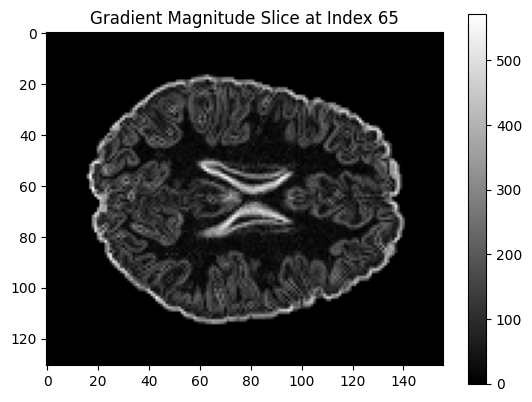

In [7]:
# Assuming grad_magnitude is computed as shown in the previous example
# Select a slice to visualize
slice_index = mri_volume.shape[2] // 2  # Example slice index
plt.imshow(grad_magnitude[:, :, slice_index], cmap='gray')
plt.colorbar()
plt.title(f'Gradient Magnitude Slice at Index {slice_index}')
plt.show()

### Gradient Direction Visualization

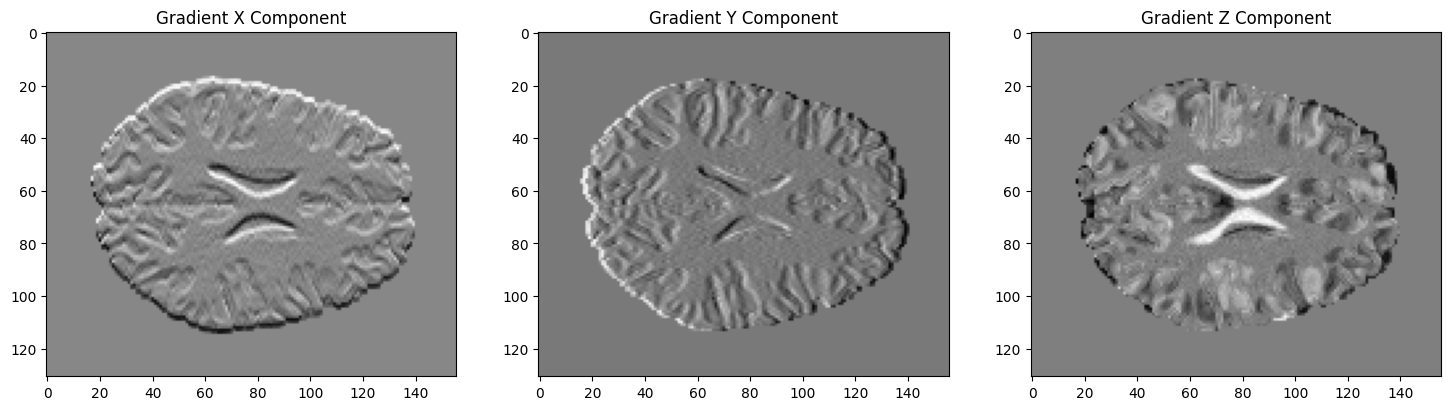

In [8]:
# Visualize the x, y, and z components of the gradient
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axes[0].imshow(grad_x[:, :, slice_index], cmap='gray')
axes[0].set_title('Gradient X Component')

axes[1].imshow(grad_y[:, :, slice_index], cmap='gray')
axes[1].set_title('Gradient Y Component')

axes[2].imshow(grad_z[:, :, slice_index], cmap='gray')
axes[2].set_title('Gradient Z Component')

plt.show()


## Initialize Gaussians

In [9]:
# Threshold to filter out low gradients
tau = grad_magnitude.mean()  # Example threshold
filtered_grad_magnitude = np.where(grad_magnitude > tau, grad_magnitude, 0)

### Gaussian Centers Based on Medium Gradient Magnitude

In [10]:
# For simplicity, let's select points with gradient magnitude around the median as centers
median_grad = np.median(filtered_grad_magnitude[filtered_grad_magnitude > 0])
close_to_median = np.abs(filtered_grad_magnitude - median_grad) < (0.01 * median_grad)
gaussian_centers = np.argwhere(close_to_median)

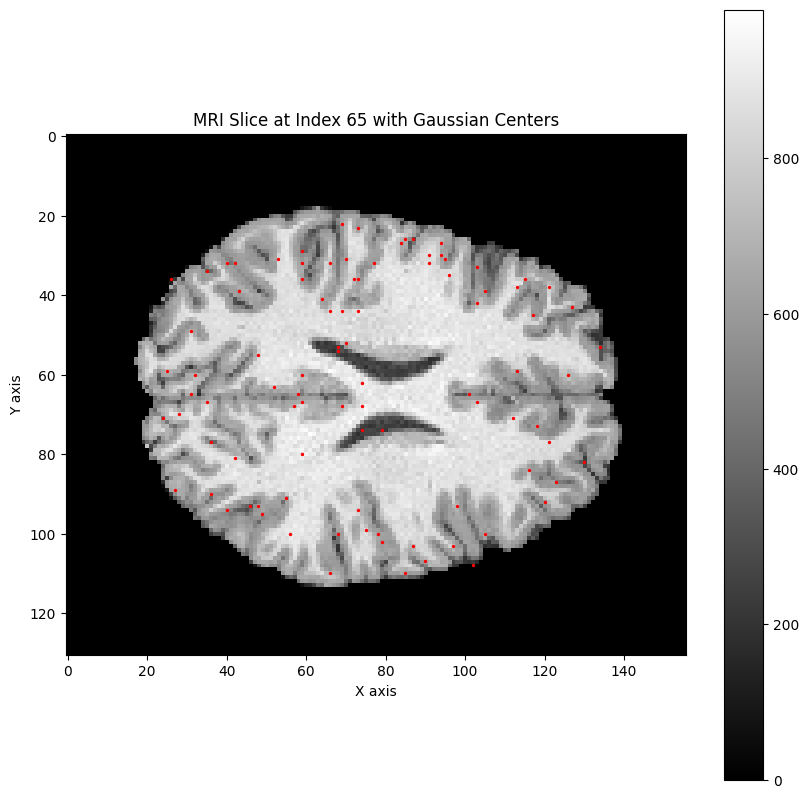

In [11]:
# Choose a slice index for visualization, e.g., the middle slice along the z-axis
slice_index = mri_volume.shape[2] // 2
slice_image = mri_volume[:, :, slice_index]

# Filter Gaussian centers that are in this slice
centers_in_slice = [center for center in gaussian_centers if center[2] == slice_index]

# Plot the MRI slice
plt.figure(figsize=(10, 10))
plt.imshow(slice_image, cmap='gray')
plt.colorbar()
plt.title(f'MRI Slice at Index {slice_index} with Gaussian Centers')

# Plot Gaussian centers on the slice
for center in centers_in_slice:
    plt.scatter(center[1], center[0], color='red', s=2)  # Note: (x, y) coordinates are inverted in plt.scatter

plt.xlabel('X axis')
plt.ylabel('Y axis')
plt.show()


### Gaussian Centers Based on High Gradient Magnitude

In [12]:
# Step 3 (Modified): Find Gaussian Centers Based on High Gradient Magnitude
# Define a high gradient threshold, for example, as the 90th percentile of the gradient magnitudes
high_grad_threshold = np.percentile(filtered_grad_magnitude[filtered_grad_magnitude > 0], 50)
high_gradient_points = np.where(filtered_grad_magnitude >= high_grad_threshold)

# Convert the high gradient points into a list of coordinates
gaussian_centers_high_grad = np.array(list(zip(*high_gradient_points)))

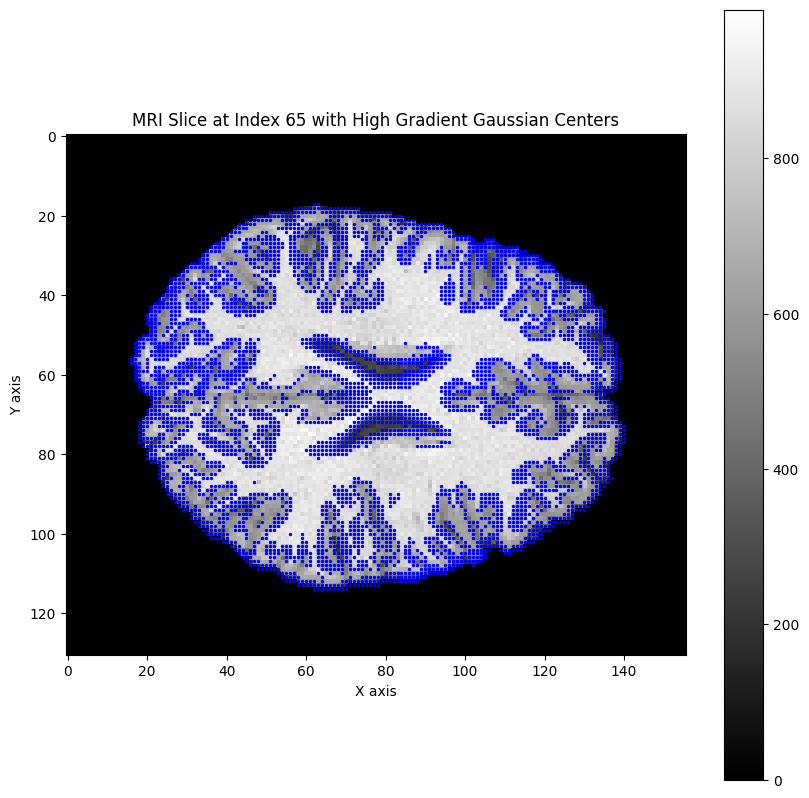

In [13]:
# Assuming we are still visualizing the same slice as before
# Filter Gaussian centers that are in this slice (for high gradient centers)
centers_in_slice_high_grad = [center for center in gaussian_centers_high_grad if center[2] == slice_index]

# Plot the MRI slice with high gradient Gaussian centers
plt.figure(figsize=(10, 10))
plt.imshow(slice_image, cmap='gray')
plt.colorbar()
plt.title(f'MRI Slice at Index {slice_index} with High Gradient Gaussian Centers')

# Plot high gradient Gaussian centers on the slice
for center in centers_in_slice_high_grad:
    plt.scatter(center[1], center[0], color='blue', s=2)  # Blue to differentiate from previous centers

plt.xlabel('X axis')
plt.ylabel('Y axis')
plt.show()


## Calculate radius and intensity

### KDTree Structure

In [14]:
def calculate_gaussian_radii_kdtree(gaussian_centers):
    kd_tree = cKDTree(gaussian_centers)

    # Define the search radius within which other centers are considered 'close'
    search_radius = 5  # Adjust this value based on your specific requirements and scale

    # Query the k-d tree for points within the search radius for each center
    # This returns a list of points for each center that are within the search radius
    counts = kd_tree.query_ball_tree(kd_tree, r=search_radius)

    # Calculate the radius inversely proportional to the number of close centers + 1 to avoid division by zero
    radii = np.array([1 / len(counts[i]) for i in range(len(gaussian_centers))])

    return radii

In [15]:
radii = calculate_gaussian_radii_kdtree(gaussian_centers)

# Assuming the intensities are still calculated directly from the voxel values
intensities = np.array([mri_volume[tuple(center)] for center in gaussian_centers])

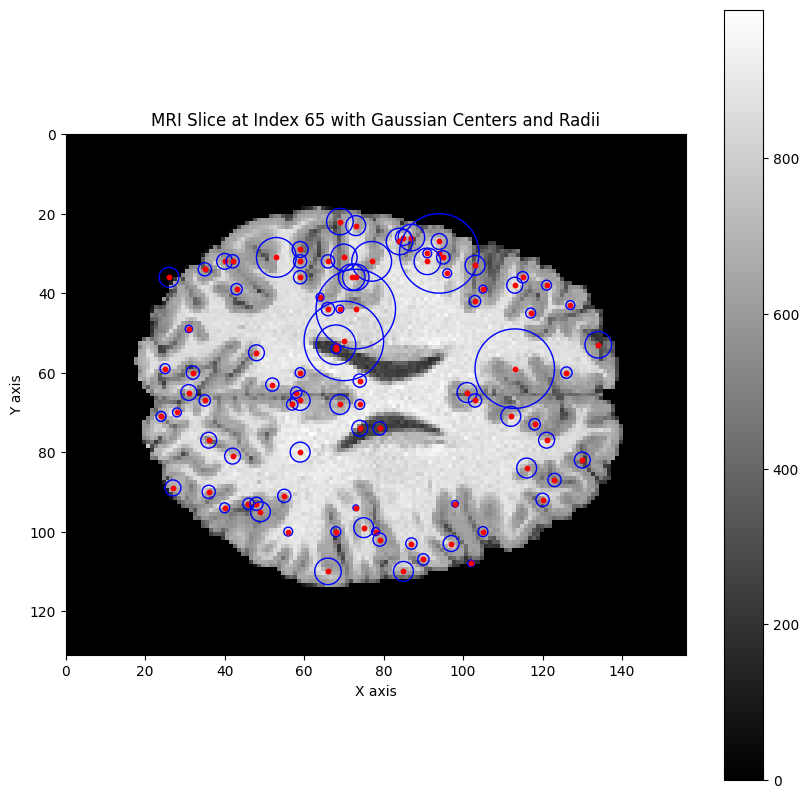

In [16]:
plt.figure(figsize=(10, 10))
plt.imshow(slice_image, cmap='gray', extent=[0, slice_image.shape[1], slice_image.shape[0], 0])
plt.colorbar()
plt.title(f'MRI Slice at Index {slice_index} with Gaussian Centers and Radii')

# Plot Gaussian centers and their radii on the slice
for center, radius in zip(centers_in_slice, radii):
    # Convert the radius to a visual scale, if necessary
    visual_radius = radius * 10  # Example scaling factor, adjust based on your specific visualization needs
    circle = plt.Circle((center[1], center[0]), visual_radius, color='blue', fill=False)
    plt.gca().add_artist(circle)
    plt.scatter(center[1], center[0], color='red', s=10)  # Center marked as a red dot

plt.xlabel('X axis')
plt.ylabel('Y axis')
plt.show()

### Example of radius calculation restricted to specific slice

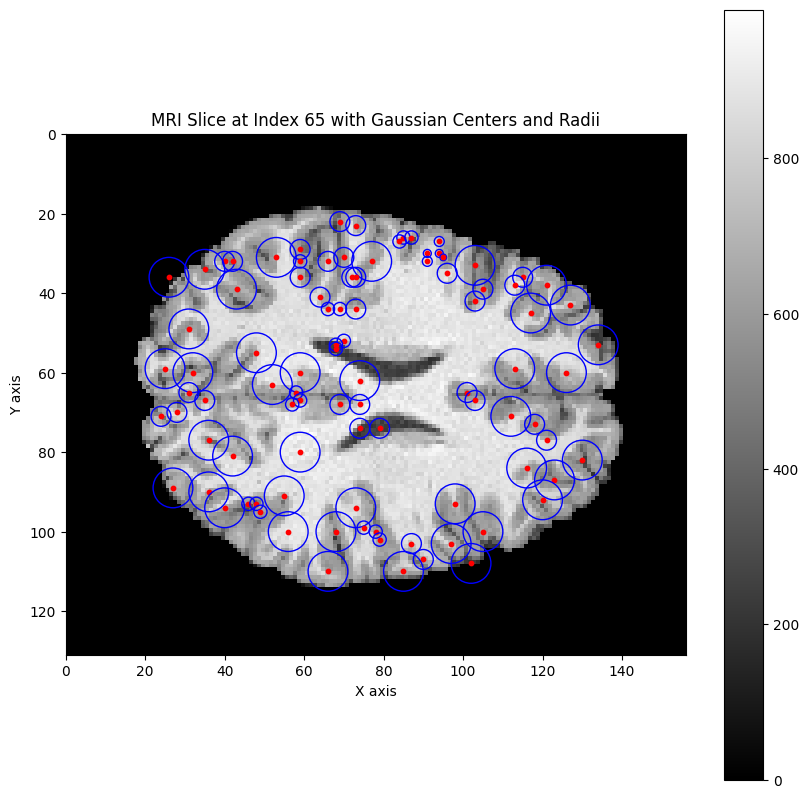

In [17]:
# Define a function to calculate the Euclidean distance between two points
radii = calculate_gaussian_radii_kdtree(centers_in_slice)

# Assuming the intensities are still calculated directly from the voxel values
intensities = np.array([mri_volume[tuple(center)] for center in centers_in_slice])

# Assuming we are still visualizing the same slice as before
# And 'radii' contains the calculated radius for each Gaussian center

plt.figure(figsize=(10, 10))
plt.imshow(slice_image, cmap='gray', extent=[0, slice_image.shape[1], slice_image.shape[0], 0])
plt.colorbar()
plt.title(f'MRI Slice at Index {slice_index} with Gaussian Centers and Radii')

# Plot Gaussian centers and their radii on the slice
for center, radius in zip(centers_in_slice, radii):
    # Convert the radius to a visual scale, if necessary
    visual_radius = radius * 5  # Example scaling factor, adjust based on your specific visualization needs
    circle = plt.Circle((center[1], center[0]), visual_radius, color='blue', fill=False)
    plt.gca().add_artist(circle)
    plt.scatter(center[1], center[0], color='red', s=10)  # Center marked as a red dot

plt.xlabel('X axis')
plt.ylabel('Y axis')
plt.show()

### Reconstruct volume

### Calculate sigmas based on distance to closest centers

In [18]:
def calculate_sigmas(normalized_centers):
    normalized_centers_np = normalized_centers.cpu().numpy()  # Make sure it's on CPU and convert to NumPy

    # Create a k-d tree from the normalized centers
    tree = cKDTree(normalized_centers_np)

    # Query the k-d tree for the 4 closest points to each center (including itself)
    distances, indices = tree.query(normalized_centers_np, k=4)

    # Exclude the nearest distance (distance to itself) and take the next three
    closest_distances = distances[:, 1:4]  # Exclude the first column, which is zero

    # Calculate the mean of these distances for each center
    sigmas = np.mean(closest_distances, axis=1)

    # If you need to use sigmas in PyTorch, convert them back to a tensor
    sigmas_tensor = torch.tensor(sigmas, dtype=torch.float, device=normalized_centers.device)

    return sigmas_tensor

C:\Users\Florin\AppData\Local\Temp\ipykernel_16748\3874477057.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:264.)
  centers_in_slice = torch.tensor(centers_in_slice)


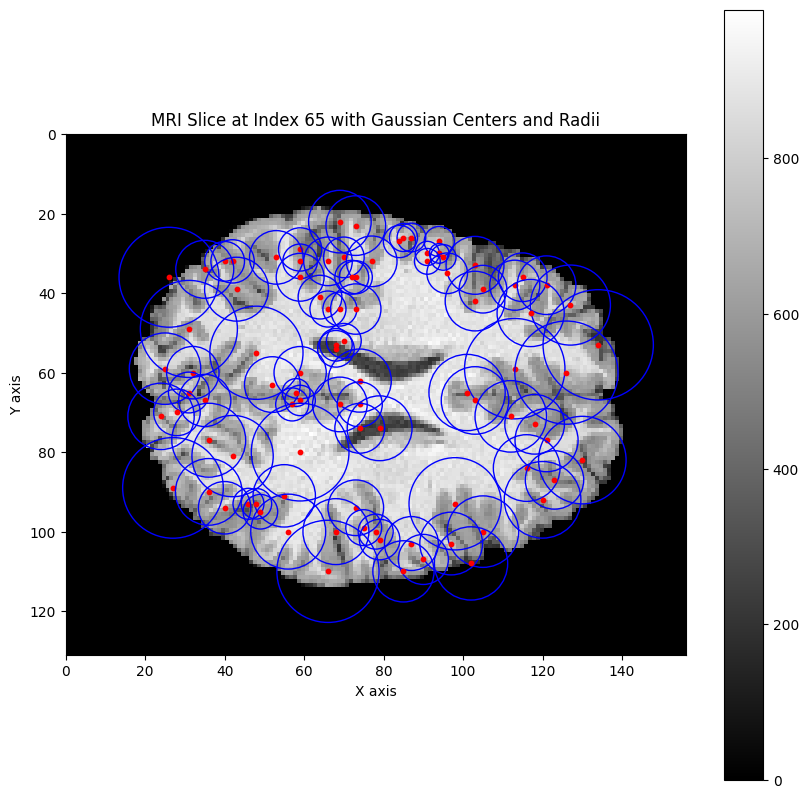

In [19]:
# Define a function to calculate the Euclidean distance between two points
centers_in_slice = torch.tensor(centers_in_slice)
radii = calculate_sigmas(centers_in_slice)

# Assuming the intensities are still calculated directly from the voxel values
intensities = np.array([mri_volume[tuple(center)] for center in centers_in_slice])

# Assuming we are still visualizing the same slice as before
# And 'radii' contains the calculated radius for each Gaussian center

plt.figure(figsize=(10, 10))
plt.imshow(slice_image, cmap='gray', extent=[0, slice_image.shape[1], slice_image.shape[0], 0])
plt.colorbar()
plt.title(f'MRI Slice at Index {slice_index} with Gaussian Centers and Radii')

# Plot Gaussian centers and their radii on the slice
for center, radius in zip(centers_in_slice, radii):
    # Convert the radius to a visual scale, if necessary
    visual_radius = radius  # Example scaling factor, adjust based on your specific visualization needs
    circle = plt.Circle((center[1], center[0]), visual_radius, color='blue', fill=False)
    plt.gca().add_artist(circle)
    plt.scatter(center[1], center[0], color='red', s=10)  # Center marked as a red dot

plt.xlabel('X axis')
plt.ylabel('Y axis')
plt.show()